# Multiple distributions

In [ ]:
using Plots
using Random
using StatsBase
using LinearAlgebra
using Printf
using Revise

In [ ]:
# local pacakges
using PolygonAlgorithms: matrix_to_points
using PolygonAlgorithms: convex_hull, intersect_convex, area_polygon
using PolygonAlgorithms: x_coords, y_coords, point_in_polygon

In [ ]:
# Ellipse
Revise.includet("ellipses/src/ellipse.jl")
Revise.includet("ellipses/src/eigenvalues.jl")
# other similarities
Revise.includet("wasserstein.jl")
Revise.includet("similarity_metrics.jl")
# Bivariate normal
include("bivariate.jl")

correlated_bivariate_normal (generic function with 2 methods)

## Generate data

https://www.probabilitycourse.com/chapter5/5_3_2_bivariate_normal_dist.php

The following are correlated with $r$:

$$
X = \mu_X + \sigma_X Z_1 \\
Y = \mu_Y + \sigma_Y \left(r Z_1 + \sqrt{1-r^2}Z_2 \right)
$$

In [ ]:
function generate_distributions(rng::AbstractRNG, r0::T, μ0::T, σ0::T, sizes::UnitRange{Int};
        N::Int=100) where T <: AbstractFloat
    r = r0 * rand(rng, N) .- 1
    μ = μ0 * (rand(rng, 2, N) .- 0.5)
    σ = σ0 * rand(rng, 2, N) .+ 0.5
    n = rand(rng, sizes, N)
    r, μ, σ, n
end

generate_distributions (generic function with 1 method)

In [ ]:
rng = MersenneTwister(314)
N = 100
rs, μs, σs, ns = generate_distributions(rng, 2.0, 10.0, 5.0, 100:500; N=N);

In [ ]:
idx = 1
x1, y1 = correlated_bivariate_normal(μs[:, idx], σs[:, idx], rs[idx], ns[idx])
# z = randn(ns[idx])
# μs[1, idx] .+ z .* σs[1, idx];
# y1 = μs[2, idx] .+ σs[2, idx] .* (rs[idx] .* z .+ sqrt(1 - rs[idx]^2) .* randn(ns[idx]));
points1 = permutedims(hcat(x1, y1))

similarities = Dict{Symbol, Vector{Float64}}()
similarities[:wasserstein] = zeros(N)
similarities[:ellipse] = zeros(N)
similarities[:polygon] = zeros(N)
for j in 1:N
    x2, y2 = correlated_bivariate_normal(μs[:, j], σs[:, j], rs[j], ns[j])
    
    points2 = permutedims(hcat(x2, y2))
    similarities[:wasserstein][j] = gaussian_wasserstein_metric(points1, points2);
    similarities[:ellipse][j] = 1 - similarities_ellipses(points1, points2);
    similarities[:polygon][j] = 1 - similarities_polygons(points1, points2);
end

In [ ]:
hcat(
    sortperm(similarities[:wasserstein]),
    sortperm(similarities[:polygon]),
    sortperm(similarities[:ellipse])
    )

100×3 Matrix{Int64}:
  1   1   1
  4   4   4
 85  93  93
 39  40  51
 51  61  39
 64  83  61
 10  51  78
 88  35  44
 66  30  35
 78  39  12
 16  66  83
 34  78  66
 83  44  30
  ⋮      
 99  10  31
 55  53   8
 25  54  65
 68  69  24
 50  25   5
 31  24  25
 48  65  26
 13   5  54
 45  26  59
 27  59  60
 24  60  68
 53  68  69

## Similarity of rankings


https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient

In [ ]:
function spearman_corr(x, y)
    rank_1 = sortperm(x)
    rank_2 = sortperm(y)
    n = length(rank_1)
    1 - 6 * sum((rank_1 - rank_2).^2)/(n * (n^2 - 1))
end

spearman_corr (generic function with 1 method)

In [ ]:
@printf("Wasserstein - ellipse:  %.5f\n", spearman_corr(similarities[:wasserstein], similarities[:ellipse]))
@printf("Wasserstein - polygon:  %.5f\n", spearman_corr(similarities[:wasserstein], similarities[:polygon]))
@printf("Polygon - ellipse:      %.5f\n", spearman_corr(similarities[:polygon], similarities[:ellipse]))

Wasserstein - ellipse:  -0.05914
Wasserstein - polygon:  -0.02310
Polygon - ellipse:      0.23849


## Plot

In [ ]:
valid = (1:N) .!= idx
other_idxs = (1:N)[valid]
rankings = sortperm(similarities[:wasserstein][valid])
j = other_idxs[rankings[1]]
println(j, " ", similarities[:wasserstein][j])

x2, y2 = correlated_bivariate_normal(μs[:, j], σs[:, j], rs[j], ns[j]);

4 4.973681811271812


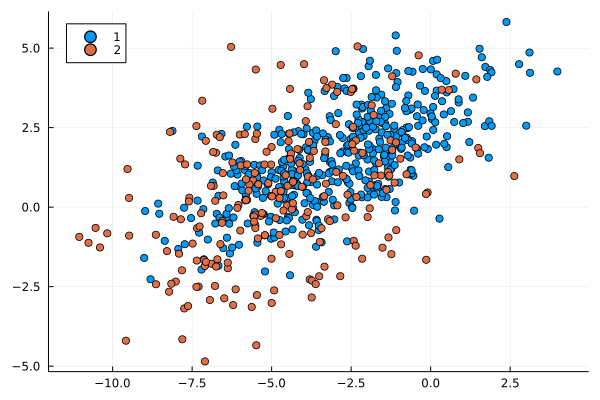

In [ ]:
double_plot = scatter(x1, y1, label="1", aspectratio=:equal)
scatter!(double_plot, x2, y2, label="2")

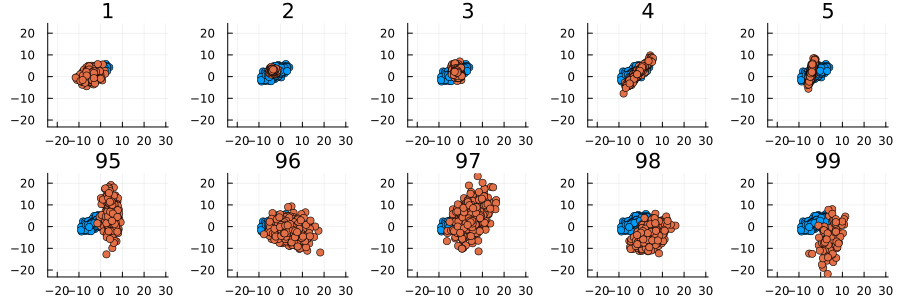

In [ ]:
sim_plots = []
for r in vcat(1:5, 95:99)
    j =  other_idxs[rankings[r]]
    x2, y2 = correlated_bivariate_normal(μs[:, j], σs[:, j], rs[j], ns[j]);
    double_plot = scatter(x1, y1, label="", aspectratio=:equal, title=r)
    scatter!(double_plot, x2, y2, label="")
    push!(sim_plots, double_plot)
end
plot(sim_plots..., layout=(2, 5), link=:all, size=(900, 300))